# L2R in AceKG
---
- with the example in DDEKG

In [94]:
import pymysql
import ujson
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import torch
np.set_printoptions(threshold = np.inf, suppress = True)

In [95]:
db = pymysql.connect(host="10.10.10.10", port=3306, user="readonly", password="readonly", db="acekg", charset="utf8")

## Data
---
- paper question id => qid (query id)

In [96]:
f_pqid = open('data/pqid.txt', 'r', encoding='utf8')
qid = {}
idq = {}
flag = 0
for line in f_pqid:
    c = line[:-1].replace("\"","").split('\t')
    qid[str(c[0]) + "@" + str(c[1])] = flag
    idq[flag] = str(c[0]) + "@" + str(c[1])
    flag += 1

### Benchmark
---
- 52 absolutely correct top3 entity

In [173]:
f_benchmark_paper_id = open('data/benchmark_paper.txt', 'r', encoding='utf8')
f_benchmark_res_top3 = open('data/benchmark_result.txt', 'r', encoding='utf8')

bm_paper = []
for line in f_benchmark_paper_id:
    bm_paper.append(line[:-1])

bm_answer = []
for line in f_benchmark_res_top3:
    bm_answer.append(line[:-1])

In [174]:
bm_paper[:2], bm_answer[:2]

(['420342715', '87250949'], ['21042067', '21042097'])

> bm_answer dpaqn_id --> ae_id

> abs_score, title_score, qa_score, word_len, letter_len, complex_len

In [175]:
def get_benchmark(paper_id):
    cur = db.cursor()
    sql='SELECT paper_id, question, abs_score, title_score, qa_score, word_len, letter_len, complex_len, ae_id FROM dde_paper_abstract_QA_ner WHERE paper_id = ' + str(paper_id)
    cur.execute(sql)
    one_paper_bm = []
    try:
        result = cur.fetchall()
        for res in result:
            para = []
            for i in range(2, 8):
                para.append(round(float(res[i]),5))
            one_line_bm = "qid:"+str(qid[str(res[0])+"@"+str(res[1])])+" aeid:"+str(res[8])+" 1:"+str(round(para[0], 5))+" 2:"+str(round(para[1], 5))+" 3:"+str(round(para[2], 5))+" 4:"+str(round(para[3], 5))+" 5:"+str(round(para[4], 5))+" 6:"+str(round(para[5], 5))
            one_paper_bm.append((one_line_bm, res[8]))
        return one_paper_bm
    except Exception as e:
        print(e)
        return one_paper_bm

In [176]:
get_benchmark(420342715)[:10]

[('qid:5123 aeid:17739994 1:0.16046 2:0.22299 3:0.36968 4:2.0 5:17.0 6:1.0',
  17739994),
 ('qid:5123 aeid:17740016 1:0.13081 2:0.14377 3:0.32 4:2.0 5:17.0 6:1.0',
  17740016),
 ('qid:5123 aeid:17740034 1:0.09939 2:0.26934 3:0.18308 4:1.0 5:10.0 6:0.0',
  17740034),
 ('qid:5123 aeid:17740052 1:0.12657 2:0.10073 3:0.3283 4:1.0 5:7.0 6:0.0',
  17740052),
 ('qid:5123 aeid:17740067 1:0.12446 2:0.25913 3:0.17614 4:1.0 5:9.0 6:0.0',
  17740067),
 ('qid:5123 aeid:17740093 1:0.10691 2:0.2087 3:0.14186 4:1.0 5:9.0 6:0.0',
  17740093),
 ('qid:5123 aeid:17740110 1:0.11803 2:0.15885 3:0.10798 4:1.0 5:11.0 6:0.0',
  17740110),
 ('qid:5123 aeid:17740126 1:0.11565 2:0.03756 3:0.2475 4:1.0 5:6.0 6:0.0',
  17740126),
 ('qid:5123 aeid:17740142 1:0.06985 2:0.02143 3:0.15978 4:1.0 5:10.0 6:0.0',
  17740142),
 ('qid:5123 aeid:17740156 1:0.0476 2:0.15894 3:0.10804 4:1.0 5:6.0 6:0.0',
  17740156)]

In [177]:
benchmark_tmp = []
for pid in tqdm(bm_paper):
    benchmark_tmp += get_benchmark(paper_id=pid)

In [178]:
benchmark = []
dp_bench = []
for tmp in benchmark_tmp:
    if str(tmp[1]) in bm_answer:
        bm_tmp = '1 ' + tmp[0]
    else:
        bm_tmp = '0 ' + tmp[0]
    benchmark.append(bm_tmp)
    dp_bench.append(tmp[1])

In [180]:
benchmark[:10], dp_bench[:10]

(['1 qid:5123 aeid:17739994 1:0.16046 2:0.22299 3:0.36968 4:2.0 5:17.0 6:1.0',
  '1 qid:5123 aeid:17740016 1:0.13081 2:0.14377 3:0.32 4:2.0 5:17.0 6:1.0',
  '0 qid:5123 aeid:17740034 1:0.09939 2:0.26934 3:0.18308 4:1.0 5:10.0 6:0.0',
  '0 qid:5123 aeid:17740052 1:0.12657 2:0.10073 3:0.3283 4:1.0 5:7.0 6:0.0',
  '0 qid:5123 aeid:17740067 1:0.12446 2:0.25913 3:0.17614 4:1.0 5:9.0 6:0.0',
  '0 qid:5123 aeid:17740093 1:0.10691 2:0.2087 3:0.14186 4:1.0 5:9.0 6:0.0',
  '0 qid:5123 aeid:17740110 1:0.11803 2:0.15885 3:0.10798 4:1.0 5:11.0 6:0.0',
  '0 qid:5123 aeid:17740126 1:0.11565 2:0.03756 3:0.2475 4:1.0 5:6.0 6:0.0',
  '0 qid:5123 aeid:17740142 1:0.06985 2:0.02143 3:0.15978 4:1.0 5:10.0 6:0.0',
  '0 qid:5123 aeid:17740156 1:0.0476 2:0.15894 3:0.10804 4:1.0 5:6.0 6:0.0'],
 [17739994,
  17740016,
  17740034,
  17740052,
  17740067,
  17740093,
  17740110,
  17740126,
  17740142,
  17740156])

In [181]:
bm = open('data/benchmark.txt', 'w', encoding='utf8')
for line in benchmark:
    print(line[:-1], file=bm)

In [182]:
bm.close()
f_benchmark_paper_id.close()
f_benchmark_res_top3.close()
f_pqid.close()

### train&test set
---
- collect by [mark.acemap.cn](mark.acemap.cn)
- **including the benchamark**, The first column is label, the second column is qid, and the following columns are features (total 6 features).

In [183]:
def get_dataset():
    dataset = []
    dp_list = []
    cur = db.cursor()
    sql='SELECT paper_id, question, abs_score, title_score,qa_score, word_len, letter_len, complex_len, mark, ae_id FROM dde_paper_abstract_QA_ner where mark is not null'
    cur.execute(sql)
    result = cur.fetchall()
    for res in result:
        para = []
        for i in range(2, 8):
            para.append(round(float(res[i]),5))
        one_line = str(res[8])+" qid:"+str(qid[str(res[0])+"@"+str(res[1])])+" aeid:"+str(res[9])+" 1:"+str(round(para[0], 5))+" 2:"+str(round(para[1], 5))+" 3:"+str(round(para[2], 5))+" 4:"+str(round(para[3], 5))+" 5:"+str(round(para[4], 5))+" 6:"+str(round(para[5], 5))
        dataset.append(one_line)
        dp_list.append(int(res[9]))
    return dataset, dp_list

In [184]:
dataset, dp_list = get_dataset()
len(dataset)

8247

In [185]:
ds = open('data/all.txt', 'w', encoding='utf8')

for line in dataset:
    print(line[:-1], file=ds)
ds.close()

In [186]:
# db.close()

- divide into train:test = 4:1

In [199]:
dataset[1]

'0 qid:4059 aeid:14753826 1:0.02323 2:0.02874 3:0.04246 4:1.0 5:10.0 6:0.0'

In [193]:
def build_dateset(dataset, dp_list):
    training_set = []
    testing_set = []
    dp_train = []
    dp_test = []
    for index in range(0, len(dataset)):
        c = dataset[index].split(" ")
        record = [int(c[0]), int(c[1].split(":")[1]), int(c[2].split(":")[1]), float(c[3].split(":")[1]), float(c[4].split(":")[1]), float(c[5].split(":")[1]), float(c[6].split(":")[1]), float(c[7].split(":")[1]),float(c[8].split(":")[1])]    
        if index < 4/5*len(dataset):
            training_set.append(record)
            dp_train.append(dp_list[index])
        else:
            testing_set.append(record)
            dp_test.append(dp_list[index])
    return training_set, testing_set, dp_train, dp_test

def build_benchmark(benchmark):
    benchmark_set = []
    for index in range(0, len(benchmark)):
        c = benchmark[index].split(" ")
        record = [int(c[0]), int(c[1].split(":")[1]), int(c[2].split(":")[1]), float(c[3].split(":")[1]), float(c[4].split(":")[1]), float(c[5].split(":")[1]), float(c[6].split(":")[1]), float(c[7].split(":")[1]),float(c[8].split(":")[1])]    
        benchmark_set.append(record)
    return benchmark_set

In [195]:
training_set, testing_set, dp_train, dp_test = build_dateset(dataset, dp_list)
benchmark_set = build_benchmark(benchmark)


In [196]:
len(benchmark_set)

2619

In [197]:
training_set[:3]
trs = np.array(training_set)
tes = np.array(testing_set)
trs[:3], tes[:3]

(array([[       1.     ,     4059.     , 14753805.     ,        0.07169,
                0.11169,        0.16501,        1.     ,        8.     ,
                0.     ],
        [       0.     ,     4059.     , 14753826.     ,        0.02323,
                0.02874,        0.04246,        1.     ,       10.     ,
                0.     ],
        [       0.     ,     4059.     , 14753946.     ,        0.03952,
                0.0438 ,        0.06472,        1.     ,        9.     ,
                0.     ]]),
 array([[       0.     ,      429.     , 13025941.     ,        0.03194,
                0.0435 ,        0.05837,        1.     ,        8.     ,
                0.     ],
        [       0.     ,      433.     , 13025952.     ,        0.12283,
                0.008  ,        0.23426,        2.     ,       19.     ,
                1.     ],
        [       0.     ,      433.     , 13025990.     ,        0.17215,
                0.     ,        0.1505 ,        1.     ,       13

In [200]:
bms = np.array(benchmark_set)
bms[:3]

array([[       1.     ,     5123.     , 17739994.     ,        0.16046,
               0.22299,        0.36968,        2.     ,       17.     ,
               1.     ],
       [       1.     ,     5123.     , 17740016.     ,        0.13081,
               0.14377,        0.32   ,        2.     ,       17.     ,
               1.     ],
       [       0.     ,     5123.     , 17740034.     ,        0.09939,
               0.26934,        0.18308,        1.     ,       10.     ,
               0.     ]])

In [201]:
np.save('train.npy', trs)
np.save('test.npy', tes)
np.save('benchmark.npy', bms)

## Before Training

In [68]:
def get_benchmark_top3(paper_id):
    cur = db.cursor()
    sql='SELECT question, res_entity FROM dde_paper_ner where paper_id = ' + str(paper_id)
    cur.execute(sql)
    result = cur.fetchall()
    top3list = {}
    for res in result:
        if res[0] not in top3list.keys():
            top3list[res[0]] = []
            top3list[res[0]].append(res[1])
        else:
            top3list[res[0]].append(res[1])
    return top3list

In [69]:
def get_bm_answer_entity(dpaqn_id):
    cur = db.cursor()
    sql='SELECT res_entity, entity_name FROM dde_paper_abstract_QA_ner WHERE dpaqn_id = ' + str(dpaqn_id)
    cur.execute(sql)
    result = cur.fetchall()[0]
    return result[0]

- bm_answer => 实际
- get_benchmark_top3 => predict

In [70]:
bf_train_predict = {}
for paper_id in tqdm(bm_paper):
    bf_train_predict[paper_id] = get_benchmark_top3(paper_id)

KeyboardInterrupt: 

## L2R Model

In [24]:
import LambdaRank as LR
import LambdaMART as LM
import RankNet as RN

In [25]:
# train_data = np.load("data/train.npy")
# test_data = np.load("data/test.npy")

In [26]:
train_data.shape

NameError: name 'train_data' is not defined

### RankNet

In [32]:
n_feature = 46
h1_units = 512
h2_units = 256
epoch = 100
learning_rate = 0.01
plot=False

- **train**

In [64]:
model = RN.RankNet(n_feature, h1_units, h2_units, epoch, learning_rate, plot)
model.fit(train_data)

Traning………………

Epoch:0, loss : 0.6975727677345276
Epoch:10, loss : 0.44026926159858704
Epoch:20, loss : 0.391196608543396
Epoch:30, loss : 0.35077837109565735
Epoch:40, loss : 0.3178143799304962
Epoch:50, loss : 0.28842833638191223
Epoch:60, loss : 0.2596825063228607
Epoch:70, loss : 0.24030372500419617
Epoch:80, loss : 0.21682649850845337
Epoch:90, loss : 0.19929306209087372


- **test**

In [68]:
k = 4
model.validate(test_data, k)

Average NDCG@4 is 0.5531070145386872


### LambdaRank

In [35]:
n_feature = trs.shape[1] - 2
h1_units = 512
h2_units = 256
epoch = 100
learning_rate = 0.0001
k = 3

**train**

In [36]:
model = LR.LambdaRank(trs, n_feature, h1_units, h2_units, epoch, learning_rate)
model.fit(k)

Training .....

Epoch:0, Average NDCG@3 : 0.4707094330847726
Epoch:1, Average NDCG@3 : 0.466638294052735
Epoch:2, Average NDCG@3 : 0.4779455669038785
Epoch:3, Average NDCG@3 : 0.48413760048711146
Epoch:4, Average NDCG@3 : 0.4810460805631436
Epoch:5, Average NDCG@3 : 0.48842148200476854
Epoch:6, Average NDCG@3 : 0.48747478829587704
Epoch:7, Average NDCG@3 : 0.4876970798978659
Epoch:8, Average NDCG@3 : 0.49224155858191115
Epoch:9, Average NDCG@3 : 0.4940271352284492
Epoch:10, Average NDCG@3 : 0.4937330829108655
Epoch:11, Average NDCG@3 : 0.4950068948223781
Epoch:12, Average NDCG@3 : 0.4950068948223781
Epoch:13, Average NDCG@3 : 0.49803430262848103
Epoch:14, Average NDCG@3 : 0.4988310407032225
Epoch:15, Average NDCG@3 : 0.5059246389618294
Epoch:16, Average NDCG@3 : 0.5045410760180887
Epoch:17, Average NDCG@3 : 0.5264258478767811
Epoch:18, Average NDCG@3 : 0.5047816902096105
Epoch:19, Average NDCG@3 : 0.632478110749474
Epoch:20, Average NDCG@3 : 0.4953769277732278
Epoch:21, Average NDCG@3 

**test**

In [37]:
k = 3
ndcg = model.validate(tes, k)
print(ndcg)

[nan, 1.0, 1.0, 1.0, 0.7039180890341347, 1.0, 0.7653606369886217, 0.7653606369886217, 1.0, 0.5, nan, 0.6131471927654584, 1.0, 1.0, 0.6934264036172708, 1.0, nan, 1.0, nan, 1.0, 1.0, 0.9197207891481876, nan, 1.0, nan, nan, 1.0, nan, 1.0, 0.7653606369886217, 0.7653606369886217, 0.6934264036172708, 1.0, 0.46927872602275644, 0.9197207891481876, nan, 1.0, nan, 0.5, 0.0, 1.0, nan, 1.0, 1.0, 0.0, nan, 0.0, nan, nan, 1.0, nan, nan, nan, 1.0, 1.0, 0.3065735963827292, 0.7653606369886217, 0.23463936301137822, nan, nan, 0.5307212739772434, 1.0, 1.0, 0.6309297535714575, nan, 0.6934264036172708, 0.6131471927654584, 1.0, 1.0, 0.7039180890341347, 1.0, 0.7039180890341347, 0.7039180890341347, 0.6309297535714575, 0.7039180890341347, nan, nan, 1.0, nan, 1.0, 1.0, 0.0, 1.0, 1.0, 0.7039180890341347, 1.0, nan, 1.0, 0.3065735963827292, 1.0, 1.0, 0.7653606369886217, 0.0, 1.0, nan, 0.7653606369886217, 0.6131471927654584, 0.7653606369886217, nan, 1.0, 1.0, 1.0, 0.38685280723454163, nan, 1.0, 1.0, 1.0, 0.0, 0.6309

In [38]:
LR_res = model.predict(tes)
for i in range(0, len(LR_res)):
    print(LR_res[i], testing_set[i][0:2], dp_test[i])

3.8419511318206787 [0, 4700.0] 51892
3.569058656692505 [0, 4700.0] 51893
3.567368984222412 [0, 4700.0] 51894
3.536367416381836 [0, 4700.0] 51895
3.5316720008850098 [0, 4700.0] 51896
3.550218105316162 [0, 4700.0] 51897
3.561222553253174 [0, 4700.0] 51898
5.89975643157959 [1, 4698.0] 51899
3.9317970275878906 [1, 4698.0] 51900
4.006150245666504 [1, 4698.0] 51901
3.9993035793304443 [1, 4698.0] 51902
3.814504384994507 [0, 4698.0] 51903
3.6899826526641846 [0, 4698.0] 51904
3.743955373764038 [0, 4698.0] 51905
3.77323055267334 [1, 4698.0] 51906
3.684147596359253 [1, 4698.0] 51907
5.312163829803467 [1, 4698.0] 51908
3.6824114322662354 [0, 4698.0] 51909
3.5329649448394775 [0, 4698.0] 51910
3.529406785964966 [0, 4698.0] 51911
3.7136125564575195 [1, 4698.0] 51912
3.550217628479004 [0, 4698.0] 51913
3.557464122772217 [0, 4698.0] 51914
6.151350975036621 [1, 4699.0] 51915
4.0669264793396 [1, 4699.0] 51916
3.978938102722168 [1, 4699.0] 51917
3.9290449619293213 [0, 4699.0] 51918
3.7222812175750732 [0, 

### LambdaMART

In [45]:
number_of_trees = 20
lr = 0.01

In [46]:
model = LM.LambdaMART(trs, number_of_trees, lr)
model.fit()

Tree 0
Epoch:0, Average NDCG : 0.9997015503505989
Tree 1
Epoch:1, Average NDCG : 0.9997015503505989
Tree 2
Epoch:2, Average NDCG : 0.9997015503505989
Tree 3
Epoch:3, Average NDCG : 0.9997015503505989
Tree 4
Epoch:4, Average NDCG : 0.9997015503505989
Tree 5
Epoch:5, Average NDCG : 0.9997015503505989
Tree 6
Epoch:6, Average NDCG : 0.9997567829762541
Tree 7
Epoch:7, Average NDCG : 0.9997567829762541
Tree 8
Epoch:8, Average NDCG : 0.9997567829762541
Tree 9
Epoch:9, Average NDCG : 0.9997567829762541
Tree 10
Epoch:10, Average NDCG : 0.9997567829762541
Tree 11
Epoch:11, Average NDCG : 0.9997567829762541
Tree 12
Epoch:12, Average NDCG : 0.9997567829762541
Tree 13
Epoch:13, Average NDCG : 0.9997567829762541
Tree 14
Epoch:14, Average NDCG : 0.9997567829762541
Tree 15
Epoch:15, Average NDCG : 0.9997567829762541
Tree 16
Epoch:16, Average NDCG : 0.9997567829762541
Tree 17
Epoch:17, Average NDCG : 0.9997567829762541
Tree 18
Epoch:18, Average NDCG : 0.9997567829762541
Tree 19
Epoch:19, Average NDCG :

In [49]:
k = 4
ndcg = model.validate(tes, k)
print(ndcg)

[nan, 0.5585075862632192, 0.19519002499605084, 0.4144299250118475, 0.7653606369886217, 0.8318724637288826, 0.7039180890341347, 0.46927872602275644, 0.0, 0.0, nan, 0.6131471927654584, 0.6366824387328317, 0.8318724637288826, 0.6131471927654584, 0.7039180890341347, nan, 0.8048099750039491, nan, 1.0, 1.0, 0.9197207891481876, nan, 1.0, nan, nan, 1.0, nan, 1.0, 0.75369761125927, 0.5855700749881525, 0.8772153153380493, 0.6309297535714575, 0.5307212739772434, 0.0, nan, 1.0, nan, 1.0, 0.0, 0.6309297535714575, nan, 1.0, 1.0, 0.6309297535714575, nan, 0.43067655807339306, nan, nan, 0.5, nan, nan, nan, 1.0, 1.0, 1.0, 1.0, 0.7328286204777911, nan, nan, 0.6096199500078984, 1.0, 1.0, 1.0, nan, 0.38685280723454163, 0.8772153153380493, 0.6366824387328317, 1.0, 1.0, 0.8318724637288826, 0.8048099750039491, 0.46927872602275644, 1.0, 0.5307212739772434, nan, nan, 0.6131471927654584, nan, 0.5706417189553201, 0.7039180890341347, 0.6309297535714575, 1.0, 1.0, 0.7653606369886217, 1.0, nan, 1.0, 0.69342640361727

In [56]:
LM_res = model.predict(tes)

## Predict Evaluation
---
- 前三位标注是1的比率

In [48]:
def get_entity(dpaqn_id):
    cur = db.cursor()
    sql='SELECT entity_name FROM dde_paper_abstract_QA_ner WHERE dpaqn_id = ' + str(dpaqn_id)
    cur.execute(sql)
    result = cur.fetchall()[0]
    return result[0]

In [49]:
def top3inlist(l):
    try:
        _, top3_index =  torch.topk(torch.Tensor(l), 3)
        return top3_index.numpy().tolist()
    except:
        if len(l) == 1:
            return [0]
        else:
            return [0,1]

In [50]:
def eval_res(model_result, testing_set, dp_test):
    # print(dp_test[0])
    pe_re = {}
    pe_id = {}
    for i in range(0, len(model_result)):
        if testing_set[i][1] not in pe_re.keys():
            pe_re[testing_set[i][1]] = []
            pe_id[testing_set[i][1]] = []
            pe_re[testing_set[i][1]].append(model_result[i])
            pe_id[testing_set[i][1]].append((testing_set[i][0], dp_test[i]))
        else:
            pe_re[testing_set[i][1]].append(model_result[i])
            pe_id[testing_set[i][1]].append((testing_set[i][0], dp_test[i]))
            
    the_final_result_pre_positive = {}
    the_final_result_pre_negative = {}
    for queryid in pe_re.keys():
        tmp = top3inlist(pe_re[queryid])
        the_final_result_pre_positive[queryid] = []
        the_final_result_pre_negative[queryid] = []
        for i in range(0, len(pe_id[queryid])):
            if i in tmp:
                the_final_result_pre_positive[queryid].append(pe_id[queryid][i])
            else:
                the_final_result_pre_negative[queryid].append(pe_id[queryid][i])
                
    return the_final_result_pre_positive, the_final_result_pre_negative

- 实际：标注数据，预测：predict之后的top3
    - TP(True Positive) 真阳性：预测为正，实际也为正
    - FP(False Positive) 假阳性：预测为正，实际为负
    - FN(False Negative) 假阴性：预测为负、实际为正
    - TN(True Negative) 真阴性：预测为负、实际也为负
    - P(Precision) 精确率 P = TP/(TP+FP)
    - R(Recall) 召回率 R = TP/(TP+FN)
    - F(f1-score) F-值 F = 2PR/(P+R)

In [51]:
def factor(the_final_result_pre_positive, the_final_result_pre_negative):
    ftp = 0
    ffp = 0
    ffn = 0
    ftn = 0
    for k1 in the_final_result_pre_positive.keys():
        tmp = the_final_result_pre_positive[k1]
        # print(tmp)
        for r in tmp:
            if r[0]==1:
                ftp+=1
            else:
                ffp+=1
    for k2 in the_final_result_pre_negative.keys():
        tmp = the_final_result_pre_negative[k2]
        for r in tmp:
            if r[0]==1:
                ffn+=1
            else:
                ftn+=1
    precision = ftp/(ftp+ffp)
    recall = ftp/(ftp+ffn)
    f1_score = 2*precision*recall/(precision+recall)
    return precision, recall, f1_score

In [37]:
P, R, F1 = factor(prepos, preneg)
P, R, F1

NameError: name 'prepos' is not defined

In [38]:
prepos[4700]

NameError: name 'prepos' is not defined

## Case Study

In [49]:
for queryid in prepos.keys():
    elist = prepos[queryid]
    c = 0
    for e in elist:
        print(idq[int(queryid)], get_entity(e[1]), e[0])

384073323@problem Complication 0
384073323@problem Compositions 0
384073323@problem Carbonized 0
384073323@method Organic matter 1
384073323@method Carbonization 1
384073323@method Carbonate rock 1
384073323@method_dif Organic matter 1
384073323@method_dif Carbonate rock 1
384073323@method_dif Characteristic 0
384073323@result Organic matter 1
384073323@result Carbonization 1
384073323@result Carbonate rock 1
361238769@aim Paragenesis 1
361238769@aim Metalized 0
361238769@aim Metalation 0
361238769@methor_base Sphalerite 1
361238769@methor_base Compositing 0
361238769@methor_base Compositions 0
361238769@method_dif Concentrator 0
361238769@method_dif Concentric 0
361238769@method_dif RockNess 0
361238769@result_outperform Trace element 1
361238769@result_outperform Incorporeality 0
361238769@result_outperform Conditioning 0
361238769@experiment Thermodynamics 1
361238769@experiment Integrator 0
361238769@experiment Resultative 0
361238769@model_base Sediment 1
361238769@model_base Sedi

## Testing on Benchmark

**LambdaRank**

In [51]:
import models.LambdaRank as LR
import models.LambdaMART as LM
import models.RankNet as RN

In [52]:
import numpy as np
trs = np.load('train.npy')
tes = np.load('test.npy')
bms = np.load('benchmark.npy')

- dstibute

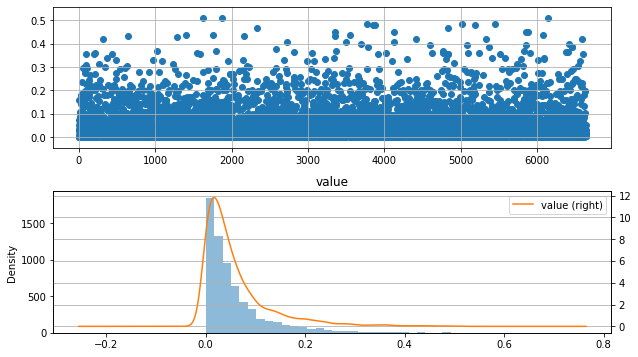

In [39]:
#导入模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.shuffle(trs[:,2])
#构造一组随机数据
s = pd.DataFrame(trs[:,2],columns = ['value'])

#画散点图和直方图
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)  # 创建子图1
ax1.scatter(s.index, s.values)
plt.grid()

ax2 = fig.add_subplot(2,1,2)  # 创建子图2
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.grid()

In [53]:
n_feature = trs.shape[1] - 2
h1_units = 512
h2_units = 256
epoch = 200
learning_rate = 0.00001
k = 3

In [54]:
lrmodel = LR.LambdaRank(trs, n_feature, h1_units, h2_units, epoch, learning_rate)
lrmodel.fit(k)
ndcg = lrmodel.validate(bms, k)
# print(ndcg)
bm_lr_res = lrmodel.predict(bms)

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

- evaluate factor

In [52]:
len(benchmark_set), len(dp_bench)
# len(testing_set), len(dp_test)

(2619, 2619)

In [53]:
lr_prepos, lr_preneg = eval_res(bm_lr_res, benchmark_set, dp_bench)
factor(lr_prepos, lr_preneg)

(0.46279949558638084, 0.5198300283286119, 0.48965977318212145)

**LambdaMART**

In [ ]:
number_of_trees = 20
lr = 0.0001
k = 3

In [ ]:
lmmodel = LM.LambdaMART(trs, number_of_trees, lr)
lmmodel.fit(k)
ndcg = lmmodel.validate(bms, k)
# print(ndcg)
bm_lm_res = lmmodel.predict(bms)

In [ ]:
lm_prepos, lm_preneg = eval_res(bm_lm_res, benchmark_set, dp_bench)
factor(lm_prepos, lm_preneg)

In [ ]:
from torch.utils.data import DataLoder

In [ ]:
a = [('1',1),('2',2),('5',5),('4',4)]
sorted(a,key=lambda x:x[1])[::-1]

In [ ]:
a = np.array([[1,2],[3,4]])

In [ ]:
a

In [ ]:
sorted(a.tolist(),key = lambda x:x[1])[::-1][:2]

In [ ]:
b

In [ ]:
import torch
a = torch.randn(5, 1)
b = torch.randn(5, 1)
print(a);print(b)

In [ ]:
torch.cat((a,b),1)

In [35]:
number_of_trees = 20
lr = 0.0001
k = 3

In [36]:
lmmodel = LM.LambdaMART(trs, number_of_trees, lr)
lmmodel.fit(k)
ndcg = lmmodel.validate(bms, k)
# print(ndcg)
bm_lm_res = lmmodel.predict(bms)

Tree 0
Epoch:0, Average NDCG@3 : 0.9992032619252583
Tree 1
Epoch:1, Average NDCG@3 : 0.9992032619252583
Tree 2
Epoch:2, Average NDCG@3 : 0.9992032619252583
Tree 3
Epoch:3, Average NDCG@3 : 0.9992032619252583
Tree 4
Epoch:4, Average NDCG@3 : 0.9992032619252583
Tree 5
Epoch:5, Average NDCG@3 : 0.9992032619252583
Tree 6
Epoch:6, Average NDCG@3 : 0.9992032619252583
Tree 7
Epoch:7, Average NDCG@3 : 0.9992032619252583
Tree 8
Epoch:8, Average NDCG@3 : 0.9992032619252583
Tree 9
Epoch:9, Average NDCG@3 : 0.9992032619252583
Tree 10
Epoch:10, Average NDCG@3 : 0.9992032619252583
Tree 11
Epoch:11, Average NDCG@3 : 0.9992032619252583
Tree 12
Epoch:12, Average NDCG@3 : 0.9992032619252583
Tree 13
Epoch:13, Average NDCG@3 : 0.9992032619252583
Tree 14
Epoch:14, Average NDCG@3 : 0.9992032619252583
Tree 15
Epoch:15, Average NDCG@3 : 0.9992032619252583
Tree 16
Epoch:16, Average NDCG@3 : 0.9992032619252583
Tree 17
Epoch:17, Average NDCG@3 : 0.9992032619252583
Tree 18
Epoch:18, Average NDCG@3 : 0.99920326192

In [56]:
lm_prepos, lm_preneg = eval_res(bm_lm_res, benchmark_set, dp_bench)
factor(lm_prepos, lm_preneg)

(0.4728877679697352, 0.5311614730878187, 0.5003335557038026)

In [56]:
from torch.utils.data import DataLoder

ImportError: cannot import name 'DataLoder' from 'torch.utils.data' (/home/HanZhou/anaconda3/lib/python3.7/site-packages/torch/utils/data/__init__.py)

In [66]:
a = [('1',1),('2',2),('5',5),('4',4)]
sorted(a,key=lambda x:x[1])[::-1]

[('5', 5), ('4', 4), ('2', 2), ('1', 1)]

In [67]:
a = np.array([[1,2],[3,4]])

In [68]:
a

array([[1, 2],
       [3, 4]])

In [76]:
sorted(a.tolist(),key = lambda x:x[1])[::-1][:2]

[[3, 4], [1, 2]]

In [70]:
b

[array([1, 2]), array([3, 4])]

In [85]:
import torch
a = torch.randn(5, 1)
b = torch.randn(5, 1)
print(a);print(b)

tensor([[ 0.2773],
        [ 0.3530],
        [-0.0631],
        [-0.3148],
        [ 0.7475]])
tensor([[ 0.9412],
        [ 1.1126],
        [-0.4356],
        [-0.3488],
        [ 0.8223]])


In [86]:
torch.cat((a,b),1)

tensor([[ 0.2773,  0.9412],
        [ 0.3530,  1.1126],
        [-0.0631, -0.4356],
        [-0.3148, -0.3488],
        [ 0.7475,  0.8223]])